# Variational AutoEncoders on Fashion MNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb)

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import utils

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state
import optax

## 0. Train parameters

In [2]:
DATA_DIR = '../../data/CelebFaces/img_align_celeba/img_align_celeba/'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
EMBEDDING = 200
LEARNING_RATE = 5e-4
EPOCHS = 10
BETA = 1.5
VALID_SPLIT = 0.2

## 1. Prepare dataset

In [3]:
# Preprocess the image
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.
    return img

# Load CelebA dataset from directory
def get_dataset():
    # read image files from directory
    train_ds, test_ds = utils.image_dataset_from_directory(
        directory=DATA_DIR,
        labels=None,
        color_mode='rgb',
        batch_size=None,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear',
        validation_split=VALID_SPLIT,
        seed=1024,
        subset='both'
    )
    
    train_ds = train_ds.map(lambda sample: preprocess(sample))
    train_ds = train_ds.repeat(EPOCHS).shuffle(1024)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    test_ds = test_ds.map(lambda sample: preprocess(sample))
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Using 40519 files for validation.


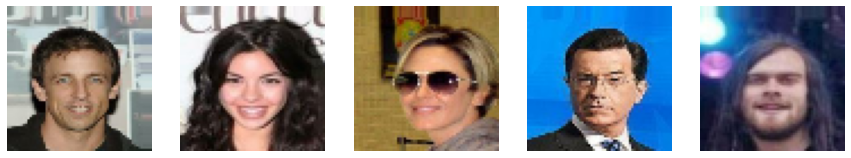

In [4]:
# CHeck dataset
check_ds, _ = get_dataset()
check_samples = next(iter(check_ds))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(check_samples[i])
    axes[i].axis('off')
plt.show()

## 2. Building the Variational AutoEncoder

In [5]:
# Encoder
class Encoder(nn.Module):
    latents: int
    num_blocks: int = 5 # The encoder has 5 identical Conv-BatchNorm-LeakyReLU blocks
    @nn.compact
    
    def __call__(self, x, train:bool):
        for i in range(self.num_blocks):
            x = nn.Conv(features=NUM_FEATURES, kernel_size=(3, 3), strides=2)(x)
            x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.leaky_relu(x)

        x = x.reshape(x.shape[0], -1)
        mean_x = nn.Dense(features=self.latents, name='z_mean')(x)
        logvar_x = nn.Dense(features=self.latents, name='z_logvar')(x)
        return mean_x, logvar_x

# Uncomment the following two lines of code to check Encoder structure
# encoder = Encoder(EMBEDDING)
# print(encoder.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 64, 64, 3)), console_kwargs={'width': 120}, train=False))


# Decoder
class Decoder(nn.Module):
    num_blocks: int = 5
    
    @nn.compact
    def __call__(self, x, train:bool):
        x = nn.Dense(features=256)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)
        x = x.reshape(x.shape[0], 2, 2, 64)

        for i in range(self.num_blocks):
            x = nn.ConvTranspose(features=NUM_FEATURES, kernel_size=(3, 3), strides=(2, 2))(x)
            x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.leaky_relu(x)

        x = nn.Conv(features=CHANNELS, kernel_size=(3, 3), strides=1)(x)
        x = nn.sigmoid(x)
        
        return x

# Uncomment the following two lines of code to check Decoder structure
# decoder = Decoder()
# print(decoder.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 200)), console_kwargs={'width': 120}, train=False))

In [6]:
# Reparameterization trick
def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = jax.random.normal(rng, logvar.shape)
    return mean + eps * std

# Variational AutoEncoder
class VAE(nn.Module):
    latents: int

    def setup(self):
        self.encoder = Encoder(self.latents)
        self.decoder = Decoder()

    def __call__(self, x, z_rng, train:bool):
        mean, logvar = self.encoder(x, train)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z, train)
        return recon_x, mean, logvar

In [7]:
# Print out model structure
vae = VAE(EMBEDDING)
rng = jax.random.PRNGKey(0)
tabulate_fn = nn.tabulate(vae, rng, console_kwargs={'width': 120})

rng, key = jax.random.split(rng)
x = jnp.ones((1, 64, 64, 3))
print(tabulate_fn(x, key, False))


                                                      VAE Summary                                                       
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path               ┃ module        ┃ inputs             ┃ outputs           ┃ batch_stats        ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│                    │ VAE           │ -                  │ -                 │                    │                   │
│                    │               │ float32[1,64,64,3] │ float32[1,64,64,… │                    │                   │
│                    │               │ - uint32[2]        │ - float32[1,200]  │                    │                   │
│                    │               │ - False            │ - float32[1,200]  │                    │                   │
├────────────────────┼─────────

### Loss function

In [8]:
@jax.vmap
def mse(recons_x, x):
    return ((recons_x - x) ** 2).sum()

@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

## 3. Create a `TrainState`

In [9]:
from typing import Any

class TrainState(train_state.TrainState):
    batch_stats: Any # For BatchNorm layers


def create_train_state(model, rng, learning_rate):
    # Initialize the model
    rng, key = jax.random.split(rng)
    variables = model.init(rng, jnp.ones([1, 64, 64, 3]), key, train=False)
    params = variables['params']
    batch_stats = variables['batch_stats']

    # Initialize optimizer
    tx = optax.adam(learning_rate=LEARNING_RATE)
    return TrainState.create(
        apply_fn=model.apply,
        params=params,
        batch_stats=batch_stats,
        tx=tx)

## 4. Train step

In [10]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params):
        (recon_x, mean, logvar), updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch,
            z_rng=z_rng,
            train=True,
            mutable=['batch_stats']
        )

        mse_loss = mse(recon_x, batch).mean()
        kl_loss = kl_divergence(mean, logvar).mean()
        loss = mse_loss + BETA * kl_loss
        return loss, updates
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    state = state.replace(batch_stats=updates['batch_stats'])
    return state

In [11]:
@jax.jit
def compute_metrics(*, state, batch, z_rng):
    recon_x, mean, logvar = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        batch,
        z_rng=z_rng,
        train=False
    )
    mse_loss = mse(recon_x, batch).mean()
    kl_loss = kl_divergence(mean, logvar).mean()
    return mse_loss, kl_loss, recon_x

## 5. Load dataset and initialize the model

In [12]:
train_ds, test_ds = get_dataset()

tf.random.set_seed(0)
rng = jax.random.PRNGKey(0)

vae = VAE(EMBEDDING)
state = create_train_state(vae, rng, LEARNING_RATE)

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Using 40519 files for validation.


## 6. Train and evaluate

In [13]:
num_steps_per_epoch = train_ds.cardinality().numpy() // EPOCHS

metrics_history = {
    'train_mse_loss': [],
    'train_kl_loss': [],
    'test_mse_loss': [],
    'test_kl_loss': []
}

In [14]:
train_mse_hist = []
train_kl_hist = []
test_mse_hist = []
test_kl_hist = []

for step, batch in enumerate(train_ds.as_numpy_iterator()):
    prev_time = time.time()
    
    rng, key = jax.random.split(rng)

    state = train_step(state, batch, key)
    train_mse, train_kl, _ = compute_metrics(state=state, batch=batch, z_rng=rng)
    train_mse_hist.append(train_mse)
    train_kl_hist.append(train_kl)

    if (step + 1) % num_steps_per_epoch == 0:
        metrics_history['train_mse_loss'].append(np.mean(train_mse_hist) / BATCH_SIZE)
        metrics_history['train_kl_loss'].append(np.mean(train_kl_hist) / BATCH_SIZE)
        train_mse_hist = []
        train_kl_hist = []

        for test_batch in test_ds.as_numpy_iterator():
            test_mse, test_kl, _ = compute_metrics(state=state, batch=test_batch, z_rng=rng)
            test_mse_hist.append(test_mse)
            test_kl_hist.append(test_kl)

        metrics_history['test_mse_loss'].append(np.mean(test_mse_hist) / BATCH_SIZE)
        metrics_history['test_kl_loss'].append(np.mean(test_kl_hist) / BATCH_SIZE)
        test_mse_hist = []
        test_kl_hist = []

        curr_time = time.time()
        print('Epoch {}: \tepoch time {:.2f} min'.format(
            (step + 1) // num_steps_per_epoch, 
            curr_time - prev_time
        ))
        print(f'\tTrain - mse_loss: {metrics_history["train_mse_loss"][-1]:.4f}, kl_loss: {metrics_history["train_kl_loss"][-1]:.4f}')
        print(f'\tTest - mse_loss: {metrics_history["test_mse_loss"][-1]:.4f}, kl_loss: {metrics_history["test_kl_loss"][-1]:.4f}')

Epoch 1: 	epoch time 2.69 min
	Train - mse_loss: 3.8788, kl_loss: 0.3709
	Test - mse_loss: 2.3498, kl_loss: 0.3456
Epoch 2: 	epoch time 2.69 min
	Train - mse_loss: 2.0969, kl_loss: 0.3337
	Test - mse_loss: 1.9675, kl_loss: 0.3228
Epoch 3: 	epoch time 2.62 min
	Train - mse_loss: 1.8405, kl_loss: 0.3166
	Test - mse_loss: 1.7604, kl_loss: 0.3228
Epoch 4: 	epoch time 2.62 min
	Train - mse_loss: 1.7382, kl_loss: 0.3183
	Test - mse_loss: 1.7011, kl_loss: 0.3198
Epoch 5: 	epoch time 2.76 min
	Train - mse_loss: 1.6776, kl_loss: 0.3233
	Test - mse_loss: 1.6515, kl_loss: 0.3320
Epoch 6: 	epoch time 2.58 min
	Train - mse_loss: 1.6427, kl_loss: 0.3281
	Test - mse_loss: 1.6207, kl_loss: 0.3342
Epoch 7: 	epoch time 2.66 min
	Train - mse_loss: 1.6054, kl_loss: 0.3327
	Test - mse_loss: 1.6175, kl_loss: 0.3307
Epoch 8: 	epoch time 2.64 min
	Train - mse_loss: 1.5822, kl_loss: 0.3372
	Test - mse_loss: 1.5622, kl_loss: 0.3418
Epoch 9: 	epoch time 2.64 min
	Train - mse_loss: 1.5618, kl_loss: 0.3392
	Test -

In [24]:
# Save model
from flax.training import orbax_utils
import orbax.checkpoint

config = {'dimensions': np.array([1, 64, 64, 3]), 'name': 'VAE'}
checkpoint = {'model': state, 'config': config}

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(checkpoint)
orbax_checkpointer.save('./models/', checkpoint, save_args=save_args, force=True)

In [28]:
# Restore model
restored = orbax_checkpointer.restore('./models/')
state = restored['model']